# 【問題1】クロスバリデーション

In [44]:
# ライブラリをインポート
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import warnings #ワーニング関連のモジュール？
warnings.filterwarnings('ignore') #ワーニングが消える？

# 読み込み
df = pd.read_csv("application_train.csv")

#抜き出し
df_selected = df.loc[:, ["AMT_INCOME_TOTAL", "AMT_CREDIT","TARGET"]]

#削除
df_selected = df_selected.dropna(how='any')
df_selected_1 = df_selected.loc[:, ["AMT_INCOME_TOTAL", "AMT_CREDIT"]]
df_selected_2 = df_selected.loc[:, ["TARGET"]]

# 単純な方法
logreg = LogisticRegression()
kf = KFold(n_splits=5)
print('Cross-validation scores: \n{}'.format(cross_val_score(logreg, df_selected_1, df_selected_2, cv=kf)))

Cross-validation scores: 
[0.91987383 0.91727098 0.91889695 0.91972619 0.92058795]


# 【問題2】グリッドサーチ

In [45]:
# ライブラリをインポート
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

In [46]:
# データの前処理
# データを分割
X_train, X_test, y_train, y_test = train_test_split(df_selected.iloc[:, :-1], df_selected.loc[:, "TARGET"], test_size=0.25, random_state=42)


In [47]:
# モデル(パイプライン)の作成
clf = Pipeline([("pca", PCA()),("lr", LogisticRegression())])

In [48]:
# 探索するパラメータの設定
# ここのkeyの指定方法が重要
params = {"pca__n_components": [2, 3, 4],"lr__penalty": ["l1", "l2"],"lr__C": [0.01, 0.1, 1, 10, 100]}

In [49]:
# グリッドサーチ
gs_clf = GridSearchCV(clf,params,cv=5)
gs_clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__C': [0.01, 0.1, 1, 10, 100],
                         'lr__penalty': ['l1', 'l2'],
                         'pca__n_components': [2, 3, 4]})

In [50]:
# 最適なパラメーター
print(gs_clf.best_params_)

# 最適なモデルの評価
best_clf = gs_clf.best_estimator_
print(classification_report(y_test, best_clf.predict(X_test)))


{'lr__C': 0.01, 'lr__penalty': 'l2', 'pca__n_components': 2}
              precision    recall  f1-score   support

           0       0.93      0.42      0.58     70687
           1       0.09      0.64      0.15      6191

    accuracy                           0.43     76878
   macro avg       0.51      0.53      0.36     76878
weighted avg       0.86      0.43      0.54     76878



# 【問題3】Kernelからの調査

- Encoding Categorical Variables  カテゴリ変数のエンコード

- Effect of Age on Repayment  返済に対する年齢の影響

- Exterior Sources  外部ソース（こちらに着目）

In [51]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = df.loc[:,['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs


,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,-0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,-0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,-0.205478
DAYS_BIRTH,0.078239,-0.600610,-0.091996,-0.205478,1.000000


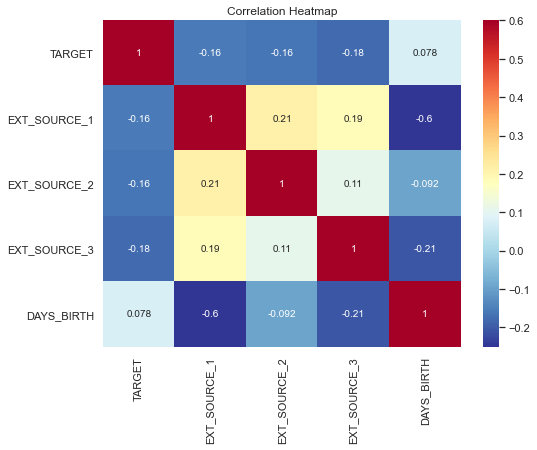

In [52]:
#可視化
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

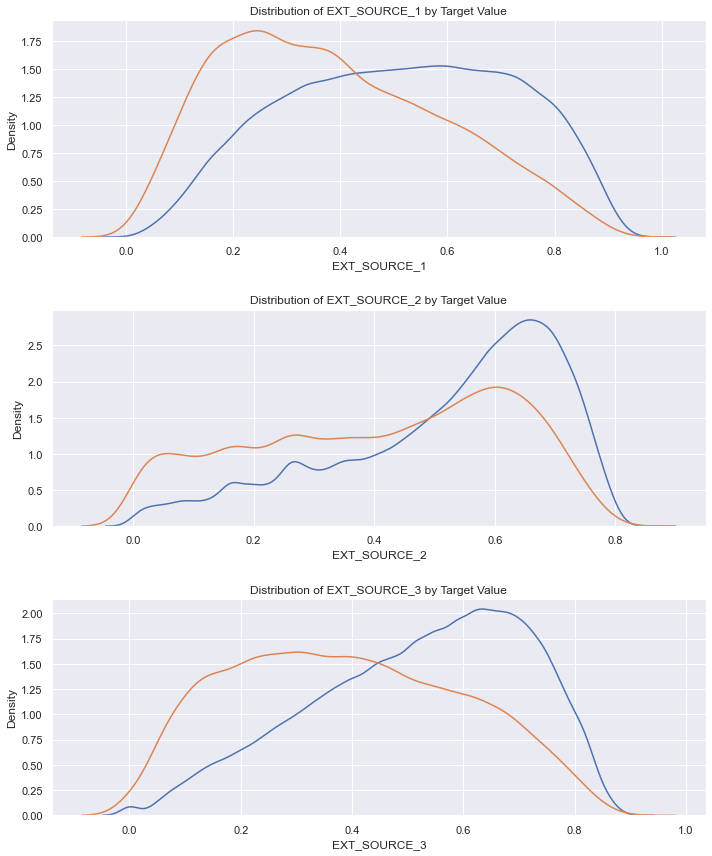

In [53]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df.loc[df['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df.loc[df['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

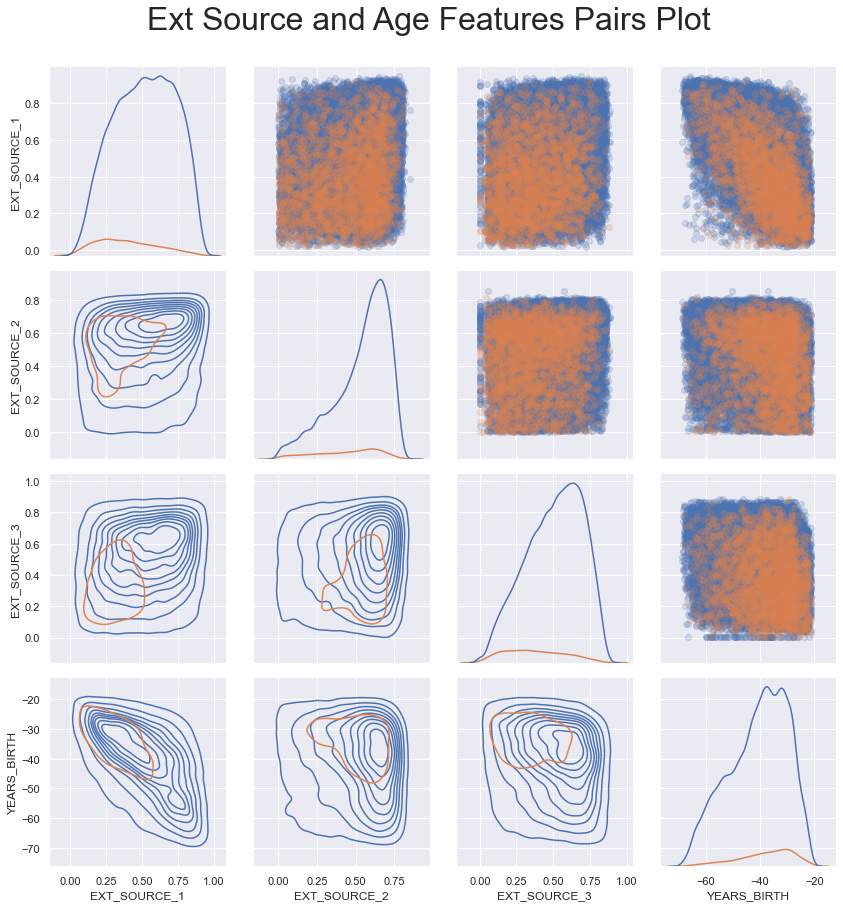

In [54]:
# Age information into a separate dataframe
age_data = df[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])
# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

In [55]:
#前処理
df2 = df.dropna(how='any')
X_train, X_test, y_train, y_test = train_test_split(df2.loc[:,['EXT_SOURCE_2','EXT_SOURCE_3']], df2.loc[:, "TARGET"], test_size=0.25, random_state=42)


In [56]:
#標準化
gs_clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__C': [0.01, 0.1, 1, 10, 100],
                         'lr__penalty': ['l1', 'l2'],
                         'pca__n_components': [2, 3, 4]})

In [57]:
# 最適なパラメーター
print(gs_clf.best_params_)

# 最適なモデルの評価
best_clf = gs_clf.best_estimator_
print(classification_report(y_test, best_clf.predict(X_test)))


{'lr__C': 0.01, 'lr__penalty': 'l2', 'pca__n_components': 2}
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2032
           1       0.00      0.00      0.00       119

    accuracy                           0.94      2151
   macro avg       0.47      0.50      0.49      2151
weighted avg       0.89      0.94      0.92      2151



# 【問題4】高い汎化性能のモデル

## SVCモデルで実装

In [58]:
#前処理
X_train, X_test, y_train, y_test = train_test_split(df2.loc[:,['EXT_SOURCE_2','EXT_SOURCE_3']], df2.loc[:, "TARGET"], test_size=0.25, random_state=42)

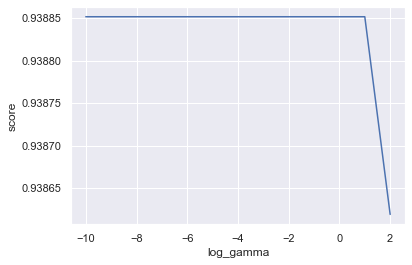

In [59]:
from sklearn.datasets import make_blobs
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import pandas as pd

#SVMで交差確認法
log_gamma = []
score = []

for i in range(-10, 3):
    model = SVC(C=1, gamma=10**i)
    scores = cross_val_score(model,df2.loc[:,['EXT_SOURCE_2','EXT_SOURCE_3']],df2.loc[:, "TARGET"], cv = 3)
    log_gamma.append(i)
    score.append(np.mean(scores))
    
# seabornでグラフ化
import seaborn as sns; sns.set()

df = pd.DataFrame()
df["log_gamma"] = log_gamma
df["score"] = score

sns.lineplot(x="log_gamma",y="score",data=df);


## 総評
- ガンマは対数表示で１を超えると精度が落ちてくるので『＜１』あたりに設定するのが良さそうである。